In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from tqdm.auto import tqdm, trange

from src.datasets.speech_equivalence import SpeechHiddenStateDataset

In [4]:
dataset_path = "outputs/preprocessed_data/timit"
hidden_states_path = "outputs/hidden_states/timit/w2v2_6/hidden_states.pkl"

model_embedding_paths = {
    "phoneme8": "outputs/model_embeddings/timit/w2v2_6/rnn_8/phoneme/embeddings.npy",
    "next_phoneme": "outputs/model_embeddings/timit/w2v2_6/rnn_8/next_phoneme/embeddings.npy",
    "syllable": "outputs/model_embeddings/timit/w2v2_6/rnn_8/syllable/embeddings.npy",
    "word": "outputs/model_embeddings/timit/w2v2_6/rnn_8/word/embeddings.npy",
}

# Number of principal components to retain in the synthetic encoding target. If `None`,
# do not perform dimensionality reduction.
num_components = 10

# Number of model embeddings to select in forward selection
num_embeddings_to_select = 3

output_dir = "."

In [ ]:
assert len(model_embedding_paths) >= num_embeddings_to_select

In [5]:
with open(hidden_states_path, "rb") as f:
    hidden_states: SpeechHiddenStateDataset = torch.load(f)

In [6]:
model_embeddings = {
    model_name: np.load(path)
    for model_name, path in model_embedding_paths.items()
}

In [7]:
for model_name, embeddings in model_embeddings.items():
    assert embeddings.shape[0] == hidden_states.num_frames, f"{model_name} {embeddings.shape[0]} {hidden_states.num_frames}"

## Model forward selection

In [8]:
select_embeddings = list(model_embeddings.keys())

In [9]:
X = np.concatenate([model_embeddings[model_name] for model_name in select_embeddings], axis=1)
Y = hidden_states.states[:, 0, :].numpy()

In [10]:
X.shape, Y.shape

((964190, 32), (964190, 768))

In [11]:
# DEV run with a tiny sample. Later we should maybe subsample intelligently
sample_idxs = np.random.choice(len(X), 100000, replace=False)
X = X[sample_idxs]
Y = Y[sample_idxs]

In [12]:
X = StandardScaler().fit_transform(X)
Y = StandardScaler().fit_transform(Y)

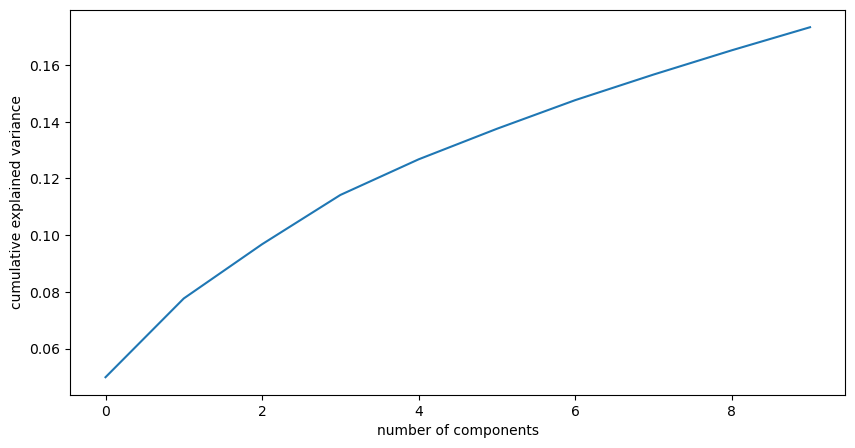

In [13]:
if num_components is not None:
    pca = PCA(n_components=num_components)
    Y = pca.fit_transform(Y)

    # plot cumulative explained variance
    f, ax = plt.subplots(figsize=(10, 5))
    ax.plot(np.cumsum(pca.explained_variance_ratio_))
    ax.set_xlabel("number of components")
    ax.set_ylabel("cumulative explained variance")

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)

In [15]:
select_embedding_mask = {}
cum_idx = 0

total_num_features = sum(embeddings.shape[1] for embeddings in model_embeddings.values())
design_matrix = np.zeros((hidden_states.num_frames, total_num_features))
for i, model_name in enumerate(select_embeddings):
    model_dim = model_embeddings[model_name].shape[1]
    select_embedding_mask[model_name] = np.zeros(total_num_features, dtype=bool)
    select_embedding_mask[model_name][cum_idx : cum_idx + model_dim] = True

    design_matrix[:, cum_idx : cum_idx + model_dim] = model_embeddings[model_name]

    cum_idx += model_dim

In [16]:
def get_design_matrix_mask(selection):
    mask = np.zeros(total_num_features, dtype=bool)
    for model_name in selection:
        mask |= select_embedding_mask[model_name]
    return mask


def estimate_model_with_selection(model, X_train, Y_train, X_test, Y_test, selection):
    mask = get_design_matrix_mask(selection)
    model = model.fit(X[:, mask], Y)

    train_score = model.score(X_train[:, mask], Y_train)
    test_score = model.score(X_test[:, mask], Y_test)
    return model, train_score, test_score

In [17]:
spec_trajectory = [[]]
model_trajectory = [None]
score_trajectory = [-np.inf]
n_embeddings_to_select = 3
assert n_embeddings_to_select <= len(select_embeddings)

# base_model = Ridge(solver="saga", max_iter=10000, random_state=0)
base_model = RidgeCV(alphas=np.logspace(-3, 3, 10),
                     cv=KFold(n_splits=5, shuffle=True, random_state=0))

for _ in trange(n_embeddings_to_select):
    candidate_embeddings = list(set(select_embeddings) - set(spec_trajectory[-1]))
    candidate_models = []
    candidate_scores = []

    for embedding_name in candidate_embeddings:
        candidate_model, _, candidate_score = estimate_model_with_selection(
            clone(base_model), X_train, Y_train, X_test, Y_test,
            spec_trajectory[-1] + [embedding_name])

        candidate_models.append(candidate_model)
        candidate_scores.append(candidate_score)
        print(f"{spec_trajectory[-1] + [embedding_name]}: {candidate_score}")

    best_candidate_score = np.max(candidate_scores)
    best_candidate_idx = np.argmax(candidate_scores)
    best_candidate_model = candidate_models[best_candidate_idx]

    if best_candidate_score > score_trajectory[-1]:
        spec_trajectory.append(spec_trajectory[-1] + [candidate_embeddings[best_candidate_idx]])
        model_trajectory.append(best_candidate_model)
        score_trajectory.append(best_candidate_score)
    else:
        print("No improvement")
        break
        

  0%|          | 0/3 [00:00<?, ?it/s]

['word']: 0.04300749920269875
['syllable']: 0.05691391932607768
['next_phoneme']: 0.0666512492885277
['phoneme8']: 0.10705666169809111
['phoneme8', 'word']: 0.1398672714963048
['phoneme8', 'syllable']: 0.150216291768349
['phoneme8', 'next_phoneme']: 0.14551766197743304
['phoneme8', 'syllable', 'word']: 0.1750804034551999
['phoneme8', 'syllable', 'next_phoneme']: 0.18423287737852131


In [18]:
list(zip(score_trajectory, spec_trajectory))

[(-inf, []),
 (0.10705666169809111, ['phoneme8']),
 (0.150216291768349, ['phoneme8', 'syllable']),
 (0.18423287737852131, ['phoneme8', 'syllable', 'next_phoneme'])]

In [ ]:
with open(f"{output_dir}/forward_selection.pkl", "wb") as f:
    pickle.dump({
        "spec_trajectory": spec_trajectory,
        "model_trajectory": model_trajectory,
        "score_trajectory": score_trajectory
    }, f)